In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

plt.style.use("fivethirtyeight")
# sns.set_palette("muted")
%matplotlib inline

### Importing ICO composite index prices

In [11]:
raw_ICO_index_data = pd.read_csv("../datasets/capstone/us_monthlycommoditypriceaverages_03927558512071.csv", encoding = "ISO-8859-1", header = 1)

In [12]:
ICO_index_data = raw_ICO_index_data.copy()
ICO_index_data = ICO_index_data.drop(labels = 0).T
ICO_index_data.rename(columns = ICO_index_data.loc["PERIOD", :], inplace = True)
ICO_index_data = ICO_index_data.drop(labels = ["PERIOD"])
ICO_index_data = ICO_index_data.apply(pd.to_numeric, errors = 'coerce')
ICO_index_data["time"] = pd.to_datetime(ICO_index_data.index.values, format = "%b%Y")

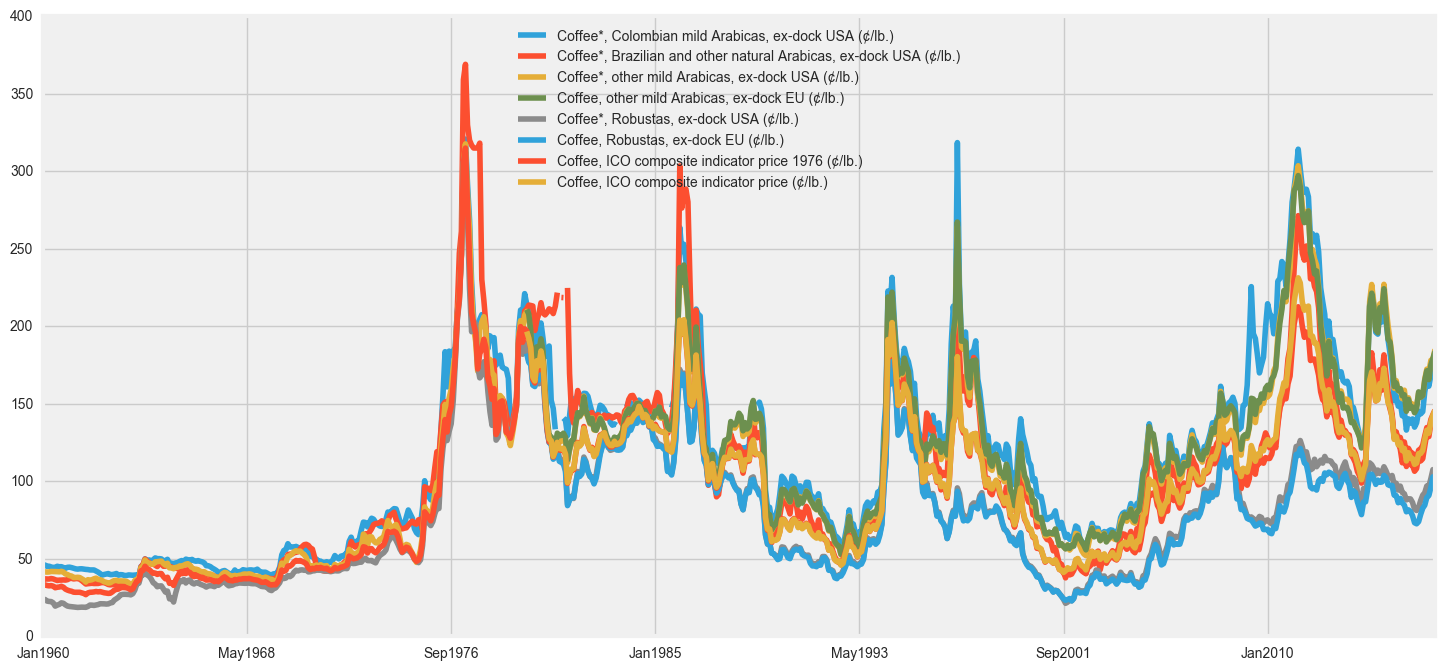

In [13]:
ICO_index_data.plot(figsize=(16,8))
sns.plt.show()

In [14]:
ICO_index_since_1989_data = ICO_index_data[ICO_index_data["time"] > datetime.date(1988,12,31)]
ICO_index_since_1989_data.index = ICO_index_since_1989_data["time"].values
ICO_index_since_1989_data.drop("time", axis = 1, inplace = True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
### Define target column

Make a column based on daily changes of the ICO composite index. Use a threshold (e.g., changes greater than ±10%); base this threshold on volatility or standard deviation.

In [21]:
ICO_index_since_1989_data["Coffee*, Brazilian and other natural Arabicas, ex-dock USA (¢/lb.)"]

1989-01-01    145.29
1989-02-01    128.72
1989-03-01    128.06
1989-04-01    131.45
1989-05-01    128.94
1989-06-01    115.02
1989-07-01     78.75
1989-08-01     67.32
1989-09-01     67.75
1989-10-01     60.32
1989-11-01     65.53
1989-12-01     67.93
1990-01-01     70.36
1990-02-01     77.59
1990-03-01     86.17
1990-04-01     87.45
1990-05-01     86.31
1990-06-01     82.94
1990-07-01     78.94
1990-08-01     90.25
1990-09-01     90.20
1990-10-01     85.78
1990-11-01     77.46
1990-12-01     80.17
1991-01-01     75.59
1991-02-01     79.39
1991-03-01     83.83
1991-04-01     81.58
1991-05-01     75.56
1991-06-01     72.44
               ...  
2014-06-01    154.02
2014-07-01    154.00
2014-08-01    171.99
2014-09-01    168.11
2014-10-01    181.58
2014-11-01    169.10
2014-12-01    157.87
2015-01-01    151.21
2015-02-01    143.32
2015-03-01    127.81
2015-04-01    131.63
2015-05-01    124.60
2015-06-01    120.85
2015-07-01    111.92
2015-08-01    118.39
2015-09-01    109.53
2015-10-01   

### Defining season

In [2]:
northern_hemisphere_seasons = {1: 'winter', 2: 'winter', 3: 'winter', 4: 'spring', 5: 'spring', 6: 'spring', 7: 'summer', 8: 'summer', 9: 'summer', 10: 'fall', 11: 'fall', 12: 'fall'}
southern_seasons = {7: 'winter', 8: 'winter', 9: 'winter', 10: 'spring', 11: 'spring', 12: 'spring', 1: 'summer', 2: 'summer', 3: 'summer', 4: 'fall', 5: 'fall', 6: 'fall'}

def get_season (month, seasons_dictionary = None):
    season = seasons_dictionary[month]
    return season

### Finding the coffee production schedule

In [3]:
pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0).head(8)

,Producing Country,Coffee Type,Harvest Begins,Harvest Ends,Year-round Harvest
0,Angola,Arabica,April,June,False
1,Angola,Robusta,May,September,False
2,Benin,Robusta,November,February,False
3,Bolivia,Arabica,April,August,False
4,Borneo,Arabica,June,December,False
5,Borneo,Robusta,May,December,False
6,Brazil,Arabica,April,September,False
7,Brazil,Robusta,April,September,False


### Selecting weather stations by growing conditions

Selection criteria:
* Elevation in meters. Look between 548 m - 1100 m (1800-3600 feet) for latitudes between 16 and 24 degrees, or 1097 m - 1920 m (3600 feet to 6300 feet).
* Robusta grows best in elevations 0 m - 914 m (sea level-3000 feet) in latitudes between ±10°. 
* The ICA quota system collapsed in 1989. Look for data that exists between 1990 and 2017.

In [4]:
raw_station_ids = pd.read_csv("../datasets/capstone/NOAA-station-ids-isd-history.txt", header = 17)

In [5]:
station_ids = raw_station_ids.copy()
station_ids_column_names = station_ids.columns[0].split()
station_ids = station_ids.iloc[:, 0].str.split(expand = True)

In [6]:
brazilian_station_ids = station_ids[station_ids[3] == "BR"].dropna(axis = 1)
brazilian_station_ids.columns = ["USAF", "WBAN", "City", "Country", "Latitude", "Longitude", "Elevation", "Begin", "End"]
brazilian_station_ids.drop(21926, inplace = True) # Error in formatting
brazilian_station_ids.reset_index(drop = True, inplace = True)
brazilian_station_ids.loc[:, ["Latitude", "Longitude", "Elevation"]] = brazilian_station_ids[["Latitude", "Longitude", "Elevation"]].apply(pd.to_numeric, errors = 'coerce')
brazilian_station_ids.dropna(inplace = True)

In [7]:
# Elevation in meters. Look between 548 m - 1100 m (1800-3600 feet) for latitudes between 16 and 24 degrees, or 1097 m - 1920 m (3600 feet to 6300 feet)
arabica_growing_conditions_criteria = (brazilian_station_ids["Elevation"] >= 548) & (brazilian_station_ids["Elevation"] <= 1100) & (brazilian_station_ids["Latitude"].abs() > 16) & (brazilian_station_ids["Latitude"].abs() <= 24)
arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((brazilian_station_ids["Elevation"] >= 1097) & (brazilian_station_ids["Elevation"] <= 1920) & (brazilian_station_ids["Latitude"].abs() <= 10))

# Robusta grows best in elevations 0 m - 914 m (sea level-3000 feet) in latitudes between ±10° 
robusta_growing_conditions_criteria = (brazilian_station_ids["Elevation"] <= 914) & (brazilian_station_ids["Latitude"].abs() <= 10)

# Look for data that exists between 1990 and 2017
time_availability_criteria = (brazilian_station_ids["Begin"].astype(int) < 19900000) & (brazilian_station_ids["End"].astype(int) > 20160000)

# Applying criteria
brazilian_station_ids = brazilian_station_ids[arabica_growing_conditions_criteria & time_availability_criteria]

### Downloading weather data from NCDC at NOAA

In [8]:
# Import NOAA data for Brazil
raw_brazil_weather_data = pd.read_csv("../datasets/capstone/Weather for Arabica producing locations Brazil 1989 - 2013 -- CDO537887251283.txt")

In [9]:
brazil_weather_data = raw_brazil_weather_data.copy()

# Removing whitespace from columns names
clean_brazil_weather_data_column_names = []
for column in brazil_weather_data.columns:
    clean_brazil_weather_data_column_names.append(column.strip())
brazil_weather_data.columns = clean_brazil_weather_data_column_names

# Dropping unnecessary columns
brazil_weather_data.drop(labels = ["Unnamed: 22"], axis = 1, inplace = True)
brazil_weather_data.drop(labels = ["GUST", "SNDP"], axis = 1, inplace = True)

# Converting time column and extracting month, year
brazil_weather_data["YEARMODA"] = brazil_weather_data["YEARMODA"].apply(pd.to_datetime, format = "%Y%m%d")
brazil_weather_data.index = brazil_weather_data["YEARMODA"].values
brazil_weather_data.sort_index(inplace = True)
brazil_weather_data.drop("YEARMODA", axis = 1, inplace = True)
brazil_weather_data["month"] = brazil_weather_data.index.month
brazil_weather_data["year"] = brazil_weather_data.index.year

# Adding seasons
brazil_weather_data["season"] = brazil_weather_data["month"].apply(get_season, seasons_dictionary = southern_seasons)

# Converting temperature data to numbers
brazil_weather_data["MAX"] = brazil_weather_data["MAX"].replace("\*", "", regex = True).apply(pd.to_numeric, errors = 'coerce')
brazil_weather_data["MIN"] = brazil_weather_data["MIN"].replace("\*", "", regex = True).apply(pd.to_numeric, errors = 'coerce')

# Converting wind speed data
brazil_weather_data["WDSP"] = brazil_weather_data["WDSP"].apply(pd.to_numeric, errors = 'coerce')

# Make a column to quantify frost risk
brazil_weather_data["frost_risk"] = brazil_weather_data["WDSP"] * (brazil_weather_data["MIN"].mean() - brazil_weather_data["MIN"]) * brazil_weather_data["MIN"]

# Converting precipitation data
brazil_weather_data["prcp_code"] = brazil_weather_data["PRCP"].str[-1]
brazil_weather_data["PRCP"] = brazil_weather_data["PRCP"].str[0:-1]
brazil_weather_data["PRCP"] = brazil_weather_data["PRCP"].apply(pd.to_numeric, errors = 'coerce')

# Setting null values
brazil_weather_data[brazil_weather_data["MAX"] == 999.99] = np.NaN
brazil_weather_data[brazil_weather_data["MIN"] == 9999.9] = np.NaN
brazil_weather_data[brazil_weather_data["WDSP"] == 999.9] = np.NaN
brazil_weather_data[brazil_weather_data["PRCP"] == 99.99] = np.NaN
brazil_weather_data[brazil_weather_data["DEWP"] >= 9999] = np.NaN

# Drop null values
print("Dropping null values reduced rows by {}%.".format(100 * round(1 - brazil_weather_data.dropna().shape[0] / brazil_weather_data.shape[0], 3)))
brazil_weather_data.dropna(inplace = True)

Dropping null values reduced rows by 20.0%.


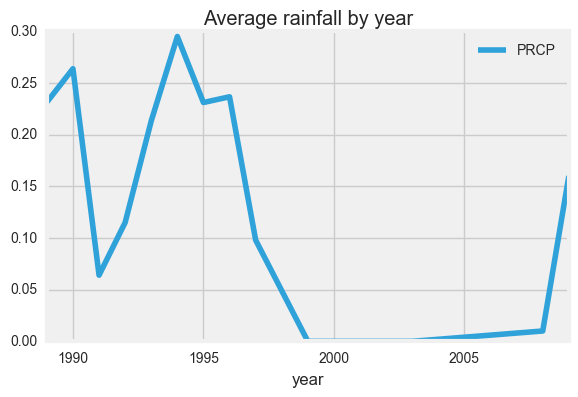

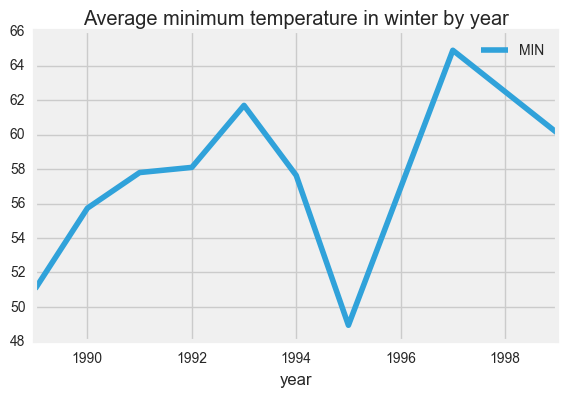

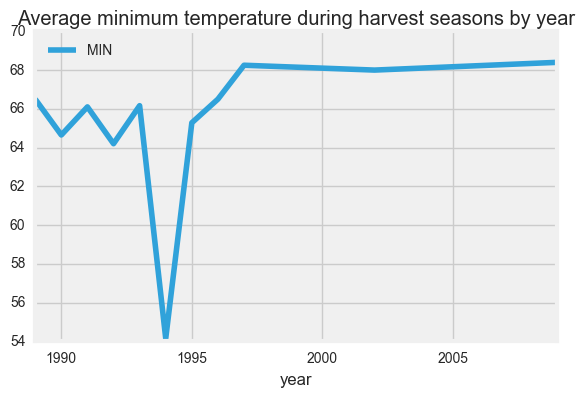

In [10]:
brazil_weather_data[["year", "PRCP"]].groupby(by = "year").mean().plot()
plt.title("Average rainfall by year")
plt.show()

brazil_weather_data[brazil_weather_data["season"] == "winter"][["year", "MIN"]].groupby(by = "year").mean().plot()
plt.title("Average minimum temperature in winter by year")
plt.show()

brazil_weather_data[(brazil_weather_data["season"] == "summer") | (brazil_weather_data["season"] == "spring")][["year", "MIN"]].groupby(by = "year").mean().plot()
plt.title("Average minimum temperature during harvest seasons by year")
plt.show()

In [15]:
time_adjusted_brazil_weather_data = brazil_weather_data.groupby(by = brazil_weather_data.index).mean().asfreq(freq = "MS", method = "backfill")

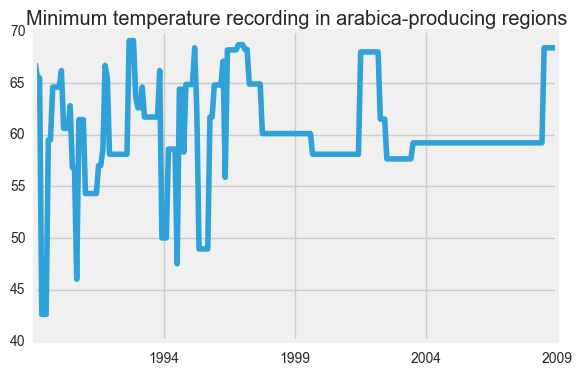

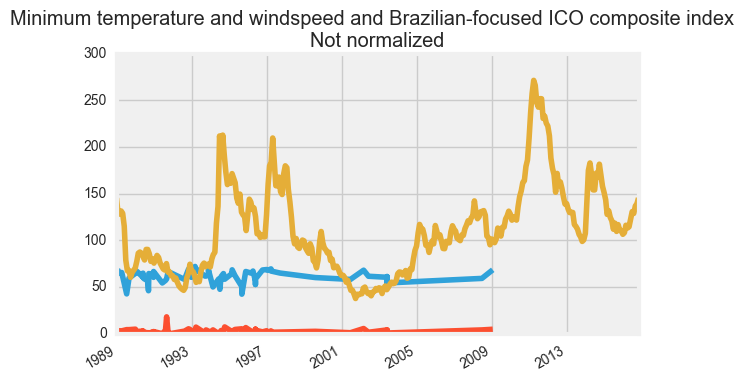

In [16]:
time_adjusted_brazil_weather_data["MIN"].plot()
plt.title("Minimum temperature recording in arabica-producing regions")
plt.show()

brazil_weather_data["MIN"].plot()
brazil_weather_data["WDSP"].plot()
ICO_index_since_1989_data["Coffee*, Brazilian and other natural Arabicas, ex-dock USA (¢/lb.)"].plot()
plt.title("Minimum temperature and windspeed and Brazilian-focused ICO composite index  \nNot normalized")
plt.show()

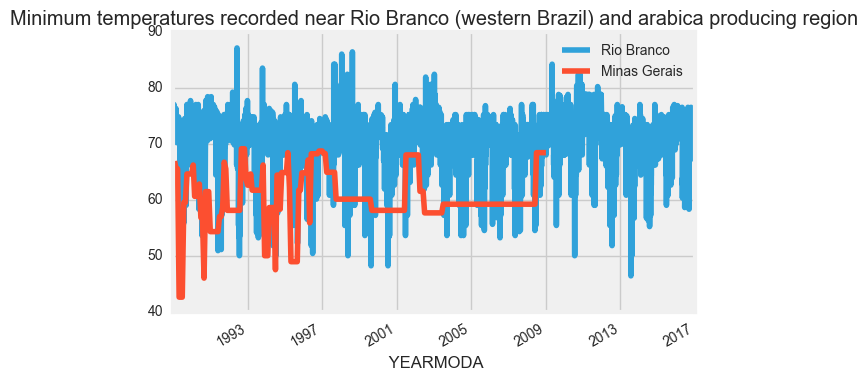

In [17]:
brazilian_weather_test_df = pd.read_csv("../datasets/capstone/Brazil-weather-JAN1980-JAN2017-NOAA-CDO8887187250151.txt")#["  MIN  "].plot()
brazilian_weather_test_df.index = brazilian_weather_test_df[" YEARMODA"].apply(pd.to_datetime, format = "%Y%m%d")

brazilian_weather_test_df[brazilian_weather_test_df.index > datetime.datetime(1988, 12, 31)]["  MIN  "].str.replace("*", "").apply(pd.to_numeric, errors = 'coerce').plot()
time_adjusted_brazil_weather_data["MIN"].plot()
plt.title("Minimum temperatures recorded near Rio Branco (western Brazil) and arabica producing region")
plt.legend(["Rio Branco", "Minas Gerais"])
plt.show()


There is a lot of missing data. But in the end, we want to know if the crop was affected by frost, or if there was a drought, or if a heat wave or cold snap affected production. We can model the former using logistic regression on all data points (and manually identify when news sources cited a frost), and look at all regional data.

### Use precipitation and minimum temperature to predict prices